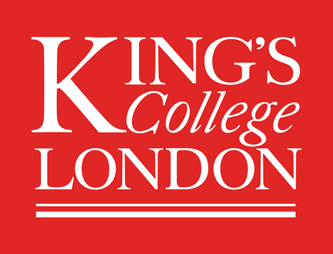


# Coursework Assignment #2

---

## King's College London

---

**Course Title**: Computational Finance MSc

**Module Name**: High-Frequency Finance

**Module Code**: 7CCSMHFF

**Module Leaders**: Dr Teresa Yu Bi and Prof. Carmine Ventre

**Student's Full Name**: Edmond Osmena

**Student ID**: K24034176

**Candidate Number**: AF15292

---
# <span style="color:blue"> Table of Contents </span>
[Introduction](#Introduction)  
[Part I: Trading strategy ](#Part-1)  
    1.1 [Import Libraries](#libraries)  
    1.2 [Data Loading and Exploration](#loading)  
    1.3 [Data Preprocessing](#preprocessing)  
    1.4 [Feature Engineering](#features)  
    1.5 [Data Validation](#validation)  
    1.6 [Data Analysis](#analysis)   
    1.7 [Instrict Time Framework and Implementation of Strategy](#strategy)    
        1.7.1 [Intrinsic Time Framework](#dc)    
        1.7.2 [Trading Strategy](#strat)    
        1.7.3 [Visualization Functions for Signal Generation](#plots)   
        1.7.4 [Application of Signal Generation, Trading Strategy & Visualizations on the 3 Pairs](#results)  
    1.8 [Pseudocodes](#pseudo)  
    1.8.1 [Intrinsic Time Framework](#itf)  
    1.8.2 [Trading Strategy](#ts)  
[Part II: Testing your strategy](#Part-2)  
    2.1 [Strategy Backtesting Frakework](#backtesting)  
    2.2 [Backtesting Results](#testresults)  
    2.3 [Backtest Pseudocode](#backtestpseudocode)   
[Results and Discussion](#RnD)  
[Conclusion](#Conclusion)  
[References](#References)

-----

# **<span style="color:blue">Introduction</span>** <a id="Introduction"></a>

This Jupyter Notebook is part of the **High-Frequency Finance** coursework, focusing on developing and testing a trading strategy on directional change. Within the report there will be Python scripting, comments within the code snipets but also explanation on markdowns. The report is structured into three parts:

1. **Trading Strategy** – Loading the data, conducting data exploration, performing data analysis and implementing a strategy based on instrict time and directional changes.  
2. **Testing your Strategy** – Backtesting the strategy and illustrating statistical results.  
3. **Results and Discussion** – Brief summary and discussion of the results.

To achieve this, the notebook includes textual explanations, screenshots, and Python code with its output where needed.

-------

# **<span style="color:blue">Part I: Trading strategy </span>** <a id="Part-1"></a>

## 1.1 Import Libraries<a id="libraries"></a>
In the Python code below, all libraries used across this coursework have been imported in this section in order to keep the code clean and organized.

In [1]:
# Data analysis libraries
import pandas as pd 
import numpy as np
from datetime import datetime # To handle datetimes

# Data visualization libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# To display multiple DFs at once
from IPython.display import display

## 1.2 Data Loading and Exploration<a id="loading"></a>
The data used in this project was sourced from [HistData.com](https://www.histdata.com/download-free-forex-data/), as recommended in the coursework specification. To ensure a comprehensive analysis, I opted for **high-frequency tick data** of Generic ASCII, which provides granular insights into market dynamics and price fluctuations. As per the coursework description, I have chosen to apply and test  the strategy on the following pairs (thus also prepare the data for these currency pairs):
1. **`CAN/JPY`**
2. **`EUR/USD`**
3. **`GBP/USD`**

In [2]:
# Read all CSVs and save them to variables
nzd_jpy = pd.read_csv("DAT_ASCII_NZDJPY_T_202411.csv") # NZD/JPY
eur_usd = pd.read_csv("DAT_ASCII_EURUSD_T_202501.csv") # EUR/USD
gbp_usd = pd.read_csv("DAT_ASCII_GBPUSD_T_202501.csv") # GBP/USD

## 1.3 Data Preprocessing <a id="preprocessing"></a>
During this stage, the data has to be prepared before the strategy is applied to it. There are several steps taken here such as:
1. **`Rename Columns`** &rarr; Renaming columns to have consistent and meaningful names, such as "Datetime", "ask_price" and "bid_price".
2. **`Datatetime Format`** &rarr; Formatting the datetime column to a standardized format that includes milliseconds (YYYY-MM-DD hh:mm:ss:mss).
3. **`Drop Not Needed Columns`** &rarr; Removing columns that contain a single value, which do not contribute to the analysis. This will also contribute helping to reduce the running time, thus faster analysis and results. This is crucial as we are analysing a HFT strategy.
4. **`Set Datetime Index`** &rarr; Set Datetime as an index to retrieve easily data but also reduce the data dimensionality.

All these steps have been efficiently performed within the `transform_dataframe()` function. This function will be applied to all three datasets, to ensure that the data structure and formatting are consistent.

In [3]:
def transform_dataframe(df):
    """
    Change Datetime format and set it as an index of the DataFrame. 
    Additionally, rename columns and drop columns with only 1 value.

    Parameters:
        df (pd.DataFrame): Input DataFrame with at least four columns.
    
    Returns:
        pd.DataFrame: Transformed DataFrame with formatted datetime column, 
                      renamed price columns, and without the last zero-filled column.
    """
    # Convert the first column to string format
    df.iloc[:, 0] = df.iloc[:, 0].astype(str)

    # Extract datetime (YYYY-MM-DD hh:mm:ss.mmm) from the first column
    df['Datetime'] = df.iloc[:, 0].apply(
        lambda x: datetime.strptime(x[:8], '%Y%m%d').strftime('%Y-%m-%d') + 
                  ' ' + x[9:11] + ':' + x[11:13] + ':' + x[13:15] + '.' + x[15:]
        )
    
    # Convert 'Datetime' column to datetime format
    df['Datetime'] = pd.to_datetime(df['Datetime'], format='%Y-%m-%d %H:%M:%S.%f')
    
    # Rename the next two columns as ask_price and bid_price
    df.rename(columns={df.columns[1]: 'ask_price', df.columns[2]: 'bid_price'}, inplace=True)
    
    # Drop the column if it contains only a single unique value
    for col in df.columns:
        if df[col].nunique() == 1:
            df.drop(col, axis=1, inplace=True)
    
    # Drop the original datetime column
    df.drop(columns=[df.columns[0]], inplace=True)
    
    # Set Datetime as the index
    df.set_index('Datetime', inplace=True)

    return df

## 1.4 Feature Engineering <a id="features"></a>
In the code below, there is a new column created that will be quite helpful for insights and analysis. The new columns are:
1. **`spread`** &rarr; difference between bid and ask. This will be used to some plotting during data analysis.
2. **`mid_price`** &rarr; average price of bid and ask prices. This is usually the market price displayed on the trading platforms and it will be used later on for the directinal change generated signals.

In [4]:
def spread(df):
    """
    Calculates the spread between bid and ask prices and adds it as a new column.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing 'bid_price' and 'ask_price' columns.
        
    Returns:
        pd.DataFrame: DataFrame with an additional 'spread' column.
    """
    df['spread'] = df['bid_price'] - df['ask_price']
    return df


def calculate_mid_price(df):
    """
    Calculates the mid price (average of bid and ask prices) for each row in the DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'bid_price' and 'ask_price' columns.

    Returns:
        pd.DataFrame: DataFrame with an additional 'mid_price' column.
    """
    df['mid_price'] = (df['bid_price'] + df['ask_price']) / 2
    return df

## 1.5 Data Validation  <a id="validation"></a>
Before proceeding with data analysis and trading strategy implementation, it is crucial to ensure that the data is clean and properly formatted. The following validation checks will be performed:

* **`Null Value Check`**: Identify columns with missing values and report their counts.
* **`Duplicate Value Check`**: Detect duplicate rows and report their count.
* **`Single Value Column Check`**: Identify columns with only one unique value and remove them.
* **`Data Type Validation`**: Verify that all columns have the expected data types.  

To perform these checks, a function named validate_data() has been created. This function takes one or more dataframes as input and returns a detailed report of the validation checks. After confirming that the datasets are valid, the data preprocessing and feature engineering function will be applied. Finally, the cleaned datasets will be displayed to verify the results.

In [5]:
def validate_data(*dfs):
    """
    Validates one or more DataFrames by checking for duplicates, null values, data types, & unique values.

    Parameters:
        *dfs (pd.DataFrame): One or more DataFrames to be validated.
        show_stats (bool): Whether to display basic descriptive statistics.

    Returns:
        None
    """
    for i, df in enumerate(dfs):
        print(f"\nValidation Report for DataFrame {i+1}")
        print("" * 50)

        df = df.reset_index()

        # Unique Values in Columns (displayed at the top)
        unique_columns = [col for col in df.columns if df[col].nunique() == 1]
        if unique_columns:
            print(f"Columns with Single Unique Values ({len(unique_columns)}):")
            print(", ".join(unique_columns))
        else:
            print("Single Value Columns: 0")

        # Duplicates (including Datetime, ask_price, bid_price, and spread)
        duplicate_count = df.duplicated(subset=['Datetime', 'ask_price', 'bid_price', 'spread']).sum()
        if duplicate_count > 0:
            print(f"Duplicate Rows: {duplicate_count}")
            print(f"Indices of Duplicates: {df[df.duplicated(subset=['Datetime', 'ask_price', 'bid_price', 'spread'])].index.tolist()}")
        else:
            print("Duplicate Rows: 0")

        # Null Values
        null_count = df.isnull().sum().sum()
        if null_count > 0:
            print(f"Null Values: {null_count}")
            print("Columns with null values:")
            print(df.isnull().sum()[df.isnull().sum() > 0])
        else:
            print("Null Values: 0")

        # Data Types
        print("\nData Types:")
        print(df.dtypes)
        print("=" * 50)

In [6]:
# Apply data preprocessing and feature engineering on initial dataset
nzd_jpy_df = calculate_mid_price(spread(transform_dataframe(nzd_jpy)))
eur_usd_df = calculate_mid_price(spread(transform_dataframe(eur_usd)))
gbp_usd_df = calculate_mid_price(spread(transform_dataframe(gbp_usd)))

# Check for data validation rules
validate_data(nzd_jpy_df, eur_usd_df, gbp_usd_df)


Validation Report for DataFrame 1

Single Value Columns: 0
Duplicate Rows: 0
Null Values: 0

Data Types:
Datetime     datetime64[ns]
ask_price           float64
bid_price           float64
spread              float64
mid_price           float64
dtype: object

Validation Report for DataFrame 2

Single Value Columns: 0
Duplicate Rows: 0
Null Values: 0

Data Types:
Datetime     datetime64[ns]
ask_price           float64
bid_price           float64
spread              float64
mid_price           float64
dtype: object

Validation Report for DataFrame 3

Single Value Columns: 0
Duplicate Rows: 0
Null Values: 0

Data Types:
Datetime     datetime64[ns]
ask_price           float64
bid_price           float64
spread              float64
mid_price           float64
dtype: object


In [7]:
# Review the data
dfs = [nzd_jpy_df, eur_usd_df, gbp_usd_df]
pairs = ['NZD/JPY', 'EUR/USD', 'GBP/USD']

for name, df in zip(pairs, dfs):
    print(f"Data for {name}:")
    display(df)
    print("\n")

Data for NZD/JPY:


,ask_price,bid_price,spread,mid_price
Datetime,,,,
2024-11-01 00:00:00.880,91.222,91.229,0.007,91.2255
2024-11-01 00:00:00.982,91.223,91.230,0.007,91.2265
2024-11-01 00:00:01.185,91.224,91.231,0.007,91.2275
2024-11-01 00:00:01.545,91.223,91.230,0.007,91.2265
2024-11-01 00:00:01.697,91.225,91.231,0.006,91.2280
...,...,...,...,...
2024-11-29 16:56:38.735,88.483,88.867,0.384,88.6750
2024-11-29 16:56:39.188,88.483,88.866,0.383,88.6745
2024-11-29 16:56:39.542,88.429,88.868,0.439,88.6485




Data for EUR/USD:


,ask_price,bid_price,spread,mid_price
Datetime,,,,
2025-01-01 17:00:14.949,1.03510,1.03585,0.00075,1.035475
2025-01-01 17:00:19.212,1.03514,1.03585,0.00071,1.035495
2025-01-01 17:02:34.026,1.03514,1.03590,0.00076,1.035520
2025-01-01 17:04:01.734,1.03514,1.03612,0.00098,1.035630
2025-01-01 17:04:30.794,1.03507,1.03612,0.00105,1.035595
...,...,...,...,...
2025-01-31 16:59:56.304,1.03599,1.03650,0.00051,1.036245
2025-01-31 16:59:56.356,1.03599,1.03642,0.00043,1.036205
2025-01-31 16:59:56.861,1.03603,1.03641,0.00038,1.036220




Data for GBP/USD:


,ask_price,bid_price,spread,mid_price
Datetime,,,,
2025-01-01 17:01:34.857,1.25134,1.25236,0.00102,1.251850
2025-01-01 17:01:38.819,1.25138,1.25236,0.00098,1.251870
2025-01-01 17:02:05.545,1.25136,1.25236,0.00100,1.251860
2025-01-01 17:04:20.239,1.25136,1.25236,0.00100,1.251860
2025-01-01 17:04:32.938,1.25136,1.25218,0.00082,1.251770
...,...,...,...,...
2025-01-31 16:59:51.738,1.23906,1.23973,0.00067,1.239395
2025-01-31 16:59:52.644,1.23906,1.23983,0.00077,1.239445
2025-01-31 16:59:55.375,1.23906,1.23973,0.00067,1.239395


## 1.6 Data Analysis  <a id="analysis"></a>
### Spread Volatility and Liquidity
The analysis focuses on identifying periods of high volatility and low liquidity by examining spread patterns. The highest spreads across all three currency pairs consistently occur around 5 PM, likely due to market overlaps between the New York and Asian sessions.

Notably, the `USD` pair datasets shows a significant spread peak around January 20th, 2025, likely triggered by Donald Trump’s tariff announcements, causing market turbulence. Similarly, the `NZD/JPY` pair shows a peak on November 24th, 2024, potentially linked to macroeconomic data releases.

These type of analysis can help you identify patterns (e.g., seasonality) and optimize trading strategies by identifying riskier trading periods.

In [8]:
def plot_spread_means(df, color):
    """
    Plots the mean spread per hour and per day as subplots (1 row, 2 columns).
    
    Parameters:
        df (pd.DataFrame): DataFrame containing 'spread' and 'Datetime' columns.
        color (str): Color of the plot lines and bars.
    """
    # Hourly Mean Calculation
    df['hour'] = pd.to_datetime(df.index).hour
    hourly_mean = df.groupby('hour')['spread'].mean()
    # Daily Mean Calculation
    df['date'] = pd.to_datetime(df.index).date
    daily_mean = df.groupby('date')['spread'].mean()

    # Create Subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot Hourly Mean Spread
    axes[0].bar(hourly_mean.index, hourly_mean.values, color=color)
    axes[0].set_title('Mean Spread per Hour')
    axes[0].set_xlabel('Hour of the Day')
    axes[0].set_ylabel('Mean Spread')
    axes[0].set_xticks(range(0, 24))
    axes[0].grid(axis='y', linestyle='--', alpha=0.5)

    # Plot Daily Mean Spread
    axes[1].plot(daily_mean.index, daily_mean.values, marker='o', linestyle='-', color=color)
    axes[1].set_title('Mean Spread per Day')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Mean Spread')
    axes[1].grid(True, linestyle='--', alpha=0.5)

    # Format x-axis to show every 7th day
    axes[1].xaxis.set_major_locator(mdates.DayLocator(interval=7))
    axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.setp(axes[1].get_xticklabels(), rotation=45)

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

    
def analyze_spread(df, color, threshold=0.025):
    """
    Displays the mean spread, and combines displays hourly and daily plots.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing 'spread' and 'Datetime' columns.
        threshold (float): Threshold level for the spread plot.
    """
    # Average spread
    avg_spread = df['spread'].mean()
    print(f"Average Spread: {avg_spread:.6f}")
    plot_spread_means(df, color)
    pass

NZD/JPY
Average Spread: 0.014642


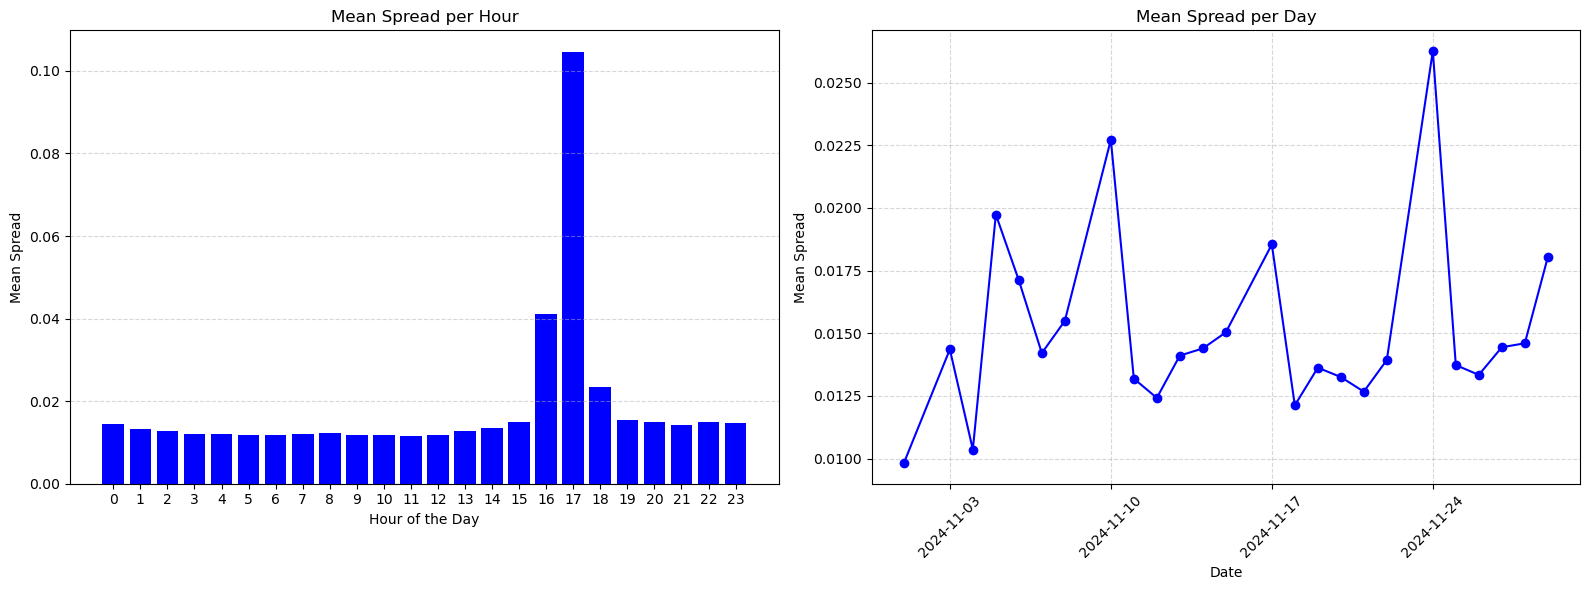


EUR/USD
Average Spread: 0.000034


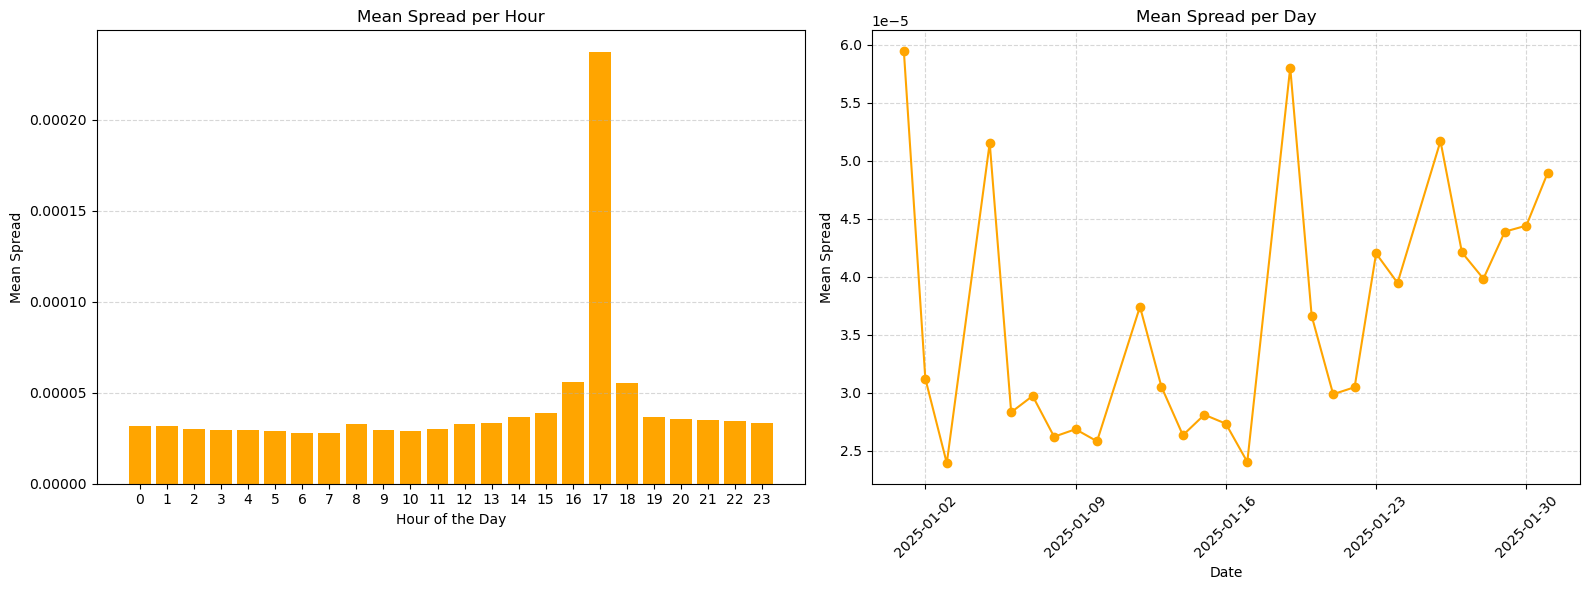


GBP/USD
Average Spread: 0.000099


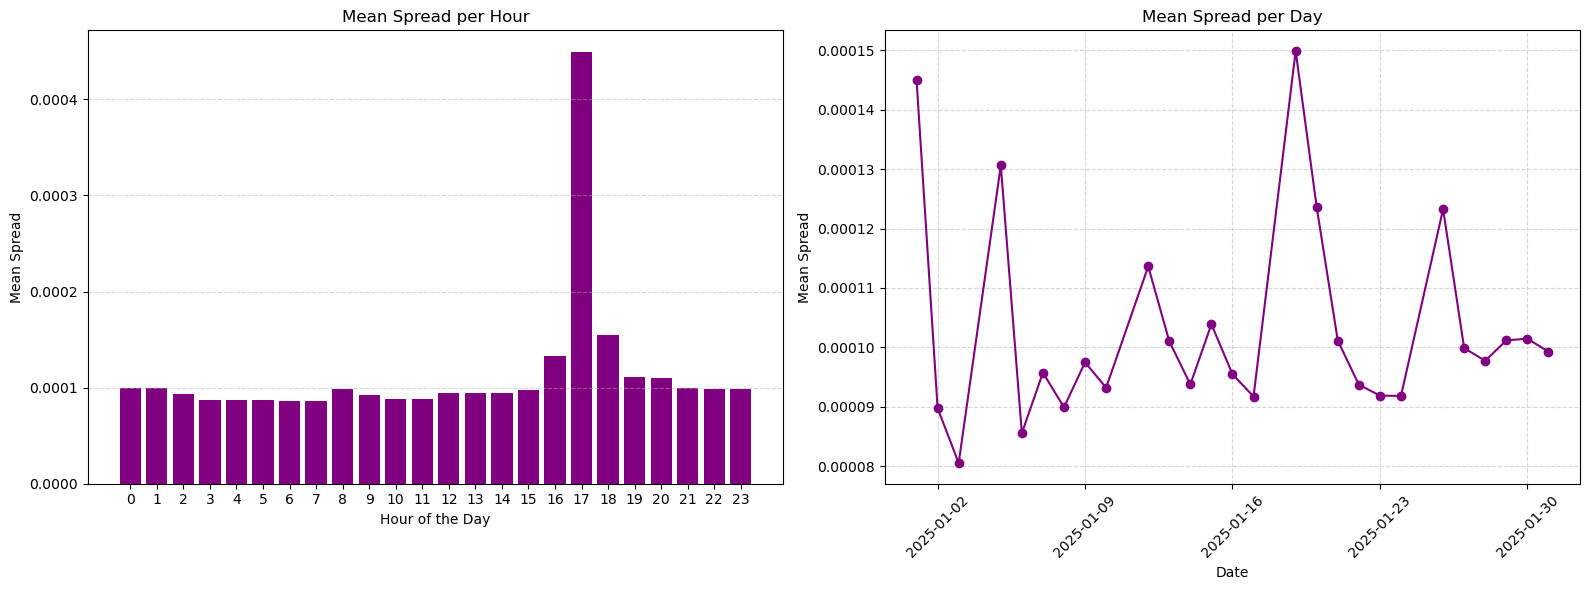

In [9]:
print("NZD/JPY")
analyze_spread(nzd_jpy_df, color="blue")

print("\nEUR/USD")
analyze_spread(eur_usd_df, color="orange")

print("\nGBP/USD")
analyze_spread(gbp_usd_df, color="purple")

## 1.7 Instrict Time Framework and Implementation of Strategy  <a id="strategy"></a>

In this section, the **Directional Change in Intrinsic Time** framework is implemented to generate signals based on significant market movements. Additionally, a **trading strategy** is built on top of the generated signals, focusing on selecting a portion of these signals that satisfy specific trading strategy confirmations. As an example printed below, for the GBP/USD 132074 signals have been generated however based on my strategy only 3816 trades would occur.

To visualize the strategy's execution and the timing of trades, two plots are presented for each currency pair:
1. **Mid Price with Trades Over Time**: This plot shows the symbol's mid-price with downsampled signals for better clarity.
2. **Density of Trades Over Time**: This bar chart visualizes the distribution of trades, highlighting periods when the trading activity was more intense.

These visualizations help identify patterns and evaluate the trading strategy's behavior over time.

### 1.7.1 Intrinsic Time Framework <a id="dc"></a>
In this section, the Intrinsic Time Framework is employed to generate trading signals for the market pairs based on the existing data. The algorithm is implemented in accordance with the pseudocode presented during the lecture *[1]*.

In [10]:
def intrinsic_event(df, delta_up, delta_down):
    """
    Detects intrinsic events (signals) using the specified thresholds for upward and downward movements.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'spread' and 'Datetime' columns.
        delta_up (float): Upward movement threshold.
        delta_down (float): Downward movement threshold.

    Returns:
        events (list): A list of detected intrinsic events with timestamps and types.
    """
    
    # Initialise variables for first time
    events = []
    S_ext = S_IE = df['mid_price'].iloc[0]
    mode = None  

    for i in range(1, len(df)):
        S_tick = df['mid_price'].iloc[i]
        
        # First tick logic
        if mode is None:  
            S_ext = S_IE = S_tick
            events.append((df.index[i], 0))
            mode = 'up' if S_tick > S_ext else 'down'
            continue

        # Up mode
        if mode == 'up':
            # Upward Directional Change Detected
            if S_tick - S_ext >= delta_up:
                mode = 'down'
                S_ext = S_tick
                S_IE = S_tick
                events.append((df.index[i], 1))
            # Downward Directional Change Detected (while in up mode)
            elif S_tick < S_ext:
                S_ext = S_tick
                # Intrinsic Event
                if S_IE - S_ext >= delta_down:
                    S_IE = S_tick
                    events.append((df.index[i], -2))
                else:
                    events.append((df.index[i], 0))

        # Down mode
        elif mode == 'down':
            # Downward Directional Change Detected
            if S_ext - S_tick >= delta_down:
                mode = 'up'
                S_ext = S_tick
                S_IE = S_tick
                events.append((df.index[i], -1))
            # Upward Directional Change Detected (while in down mode)
            elif S_tick > S_ext:
                S_ext = S_tick
                # Intrinsic Event
                if S_ext - S_IE >= delta_up:
                    S_IE = S_tick
                    events.append((df.index[i], 2))
                else:
                    events.append((df.index[i], 0))

    return events

### 1.7.2 Trading Strategy <a id="strat"></a>
After generating signals using the Intrinsic Time framework, the trading strategy selectively filters trades, executing only those that meet specific criteria. This approach is as a layer on the signals intended to enhance profitability by avoiding unnecessary trades and focusing on a specific strategy which can present opportunities. Please note that this is a long only strategy. The trading strategy is buy at the best ask price and selling (stop loss or take profit) at best bid price.

In [11]:
def trading_strategy(df, events, theta):
    """
    Long only strategy that buys only on price movement confirmation.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing price data.
        events (list): Intrinsic event signals with timestamps and types.
        theta (float): Threshold value for trading decisions.

    Returns:
        trades (list): List of trades with (timestamp, action, price).
    """
    # Initialise variables
    trades = []      # list of trades  
    position = None  # LONG or None
    P_DCC_up = None  # Price at upward directional change confirmation point

    for timestamp, signal in events:
        P_C = df.loc[timestamp, 'mid_price']  # Current price

        # Open Long Position at Upward Directional Change Confirmation
        if signal == 1 and position is None:
            P_DCC_up = P_C
            entry_price = df.loc[timestamp, 'ask_price'] # Buy at current ask_price
            trades.append((timestamp, 'BUY', entry_price))
            position = 'LONG'
        
        # Take Profit
        elif position == 'LONG' and P_C >= P_DCC_up * (1 + theta / 2):
            exit_price = df.loc[timestamp, 'bid_price'] # Sell at current bid_price
            trades.append((timestamp, 'SELL', exit_price))
            position = None

        # Stop Loss
        elif position == 'LONG' and P_C <= P_DCC_up * (1 - theta / 2):
            exit_price = df.loc[timestamp, 'bid_price'] # Sell at current bid_price
            trades.append((timestamp, 'SELL', exit_price))
            position = None

    return trades

### 1.7.3 Visualization Functions for Signal Generation <a id="plots"></a>
To visualize the results, two plots are presented. The first plot shows the mid-price movement along with downsampled trade markers, giving an overview of the most active trading periods. The second plot complements the first by offering a clearer representation of trading density, allowing for a more focused analysis of trade frequency and timing.

In [23]:
def plot_signal_density(events, color):
    """
    Plots the density of intrinsic events over time.

    Parameters:
        events (list): List of tuples containing timestamps and event types.
    """
    timestamps = [event[0] for event in events]
    plt.figure(figsize=(12, 6))
    sns.histplot(timestamps, bins=100, color=color, kde=True)
    plt.title('Density of Trades Over Time')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

    # Adjust x-axis for better readability
    plt.gca().set_xlim([min(timestamps), max(timestamps)])  # Remove extra space at start and end
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))  # Show every 3rd day
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    
def visualize_signals(df, events, color, downsample_factor=100):
    """
    Visualizes the mid price with intrinsic events or trades marked in a smart way.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing 'mid_price' column with Datetime as index.
        events (list): A list of detected intrinsic events or trades with timestamps and types.
        downsample_factor (int): Plot every N-th event to reduce clutter.
    """
    # Plot the mid price
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['mid_price'], label='Mid Price', color=color, linewidth=1)

    event_timestamps = [event[0] for event in events]
    event_types = [1 if event[1] == 'BUY' else -1 for event in events]

    # Signal vizualization
    sampled_events = list(zip(event_timestamps, event_types))[::downsample_factor]
    for timestamp, event_type in sampled_events:
        color = 'grey'
        plt.axvline(x=timestamp, color=color, linestyle='--', alpha=0.3)

    # X-axis and labeling
    plt.gca().set_xlim([df.index.min(), df.index.max()])
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=6))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    plt.title('Mid Price with Trades Over Time')
    plt.xlabel('Time')
    plt.ylabel('Mid Price')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

### 1.7.4 Application of Signal Generation & Trading on the 3 Pairs <a id="results"></a>
In this section, the Intrinsic Time framework and trading strategy have been applied to the three datasets. For the **`delta`** and **`theta`** I have chosen some values after lost of testing differnet values. Moreover, the values between the USD pairs and non-USD pair are different as their price range is very different (e.g., the eurodollar can cost like 1.03563 and the NZD/JPY 91.228 which is a ~88 time the price of the eurodollar)

The results include the number of generated signals and the number of trades extracted, along with two example pair trades (buy and sell). Visualizations highlight the density of signals and trades over time, showing periods of high trading activity. Please note that in the linechart, the straight line indicates the non tradable days and it is kept to identify whether there is any pattern or seasonality at the begining or end of each week. 

In [13]:
# Application of intrinsic_event
delta_up = delta_down = 0.0005
events = intrinsic_event(gbp_usd_df, delta_up, delta_down)
print(f"Generated GBP/USD signals: {len(events)}")

# Application of trading strategy
trades = trading_strategy(gbp_usd_df, events, 0.0001)
print(f"Generated GBP/USD trades: {len(trades)}")

# Examples of trades
print("Example of 4 GBP/USD trades:")
for trade in trades[:4]:
    print(f"Timestamp: {trade[0]}   |   Action: {trade[1]}   |   Price: {trade[2]}")

Generated GBP/USD signals: 132074
Generated GBP/USD trades: 3816
Example of 4 GBP/USD trades:
Timestamp: 2025-01-01 18:04:39.965000   |   Action: BUY   |   Price: 1.25111
Timestamp: 2025-01-01 18:05:05.202000   |   Action: SELL   |   Price: 1.2514
Timestamp: 2025-01-01 19:43:39.278000   |   Action: BUY   |   Price: 1.25139
Timestamp: 2025-01-01 19:44:03.495000   |   Action: SELL   |   Price: 1.25158


NZD/JPY


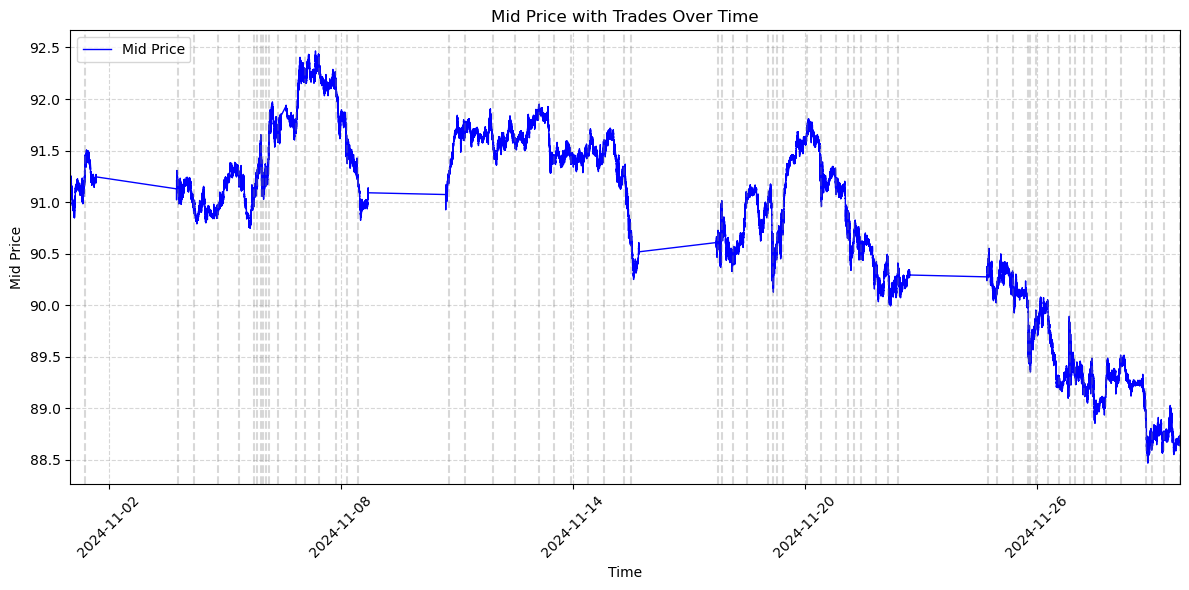

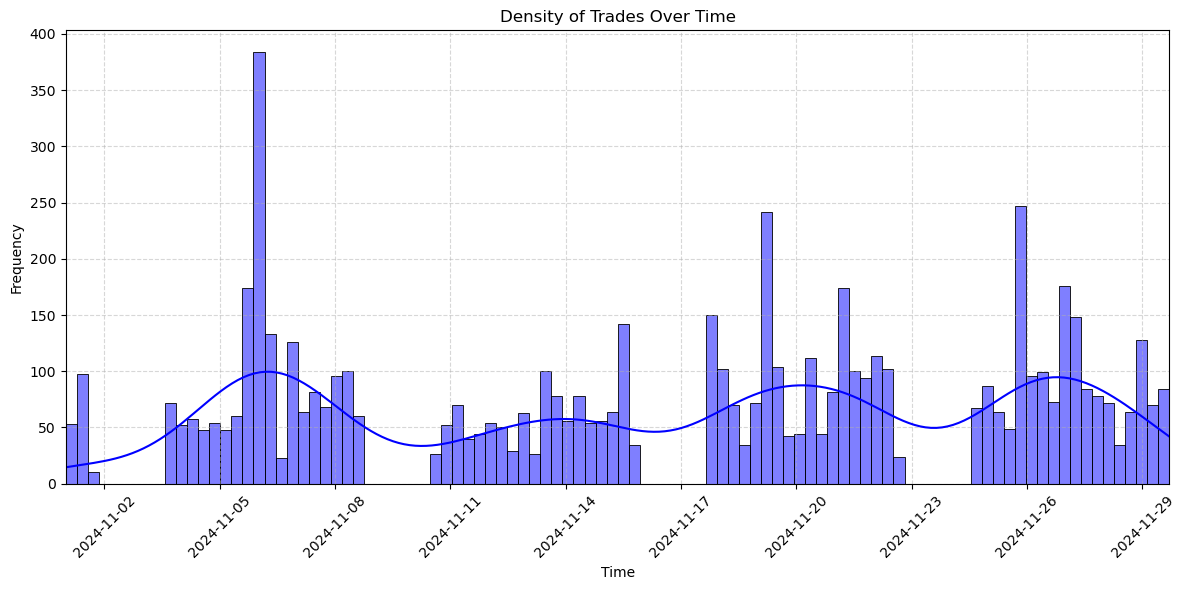

EUR/USD


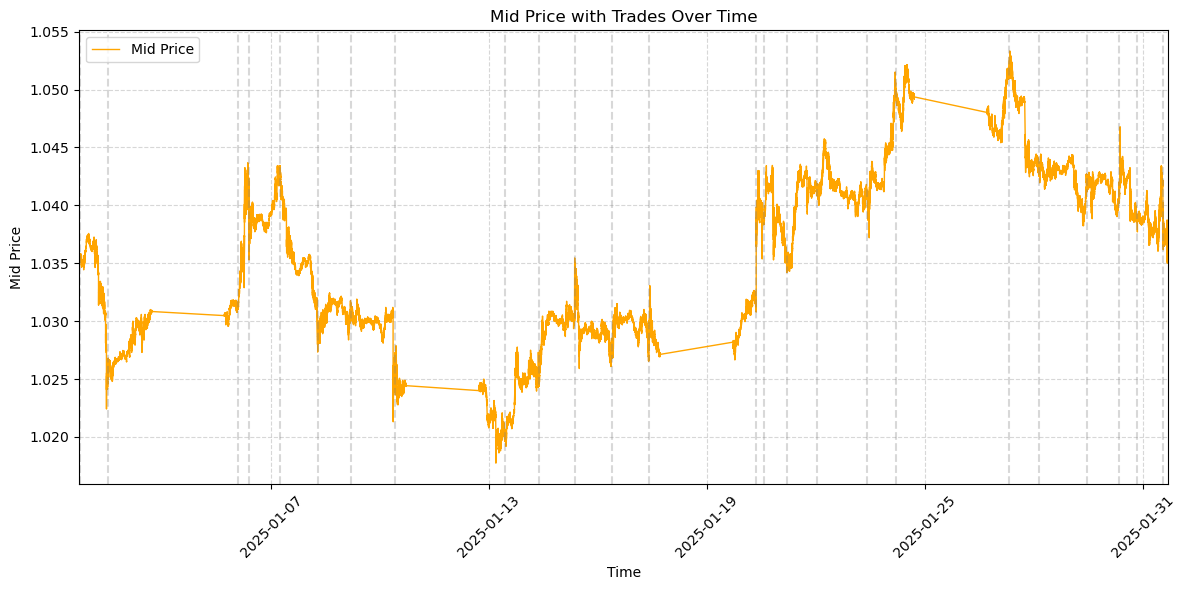

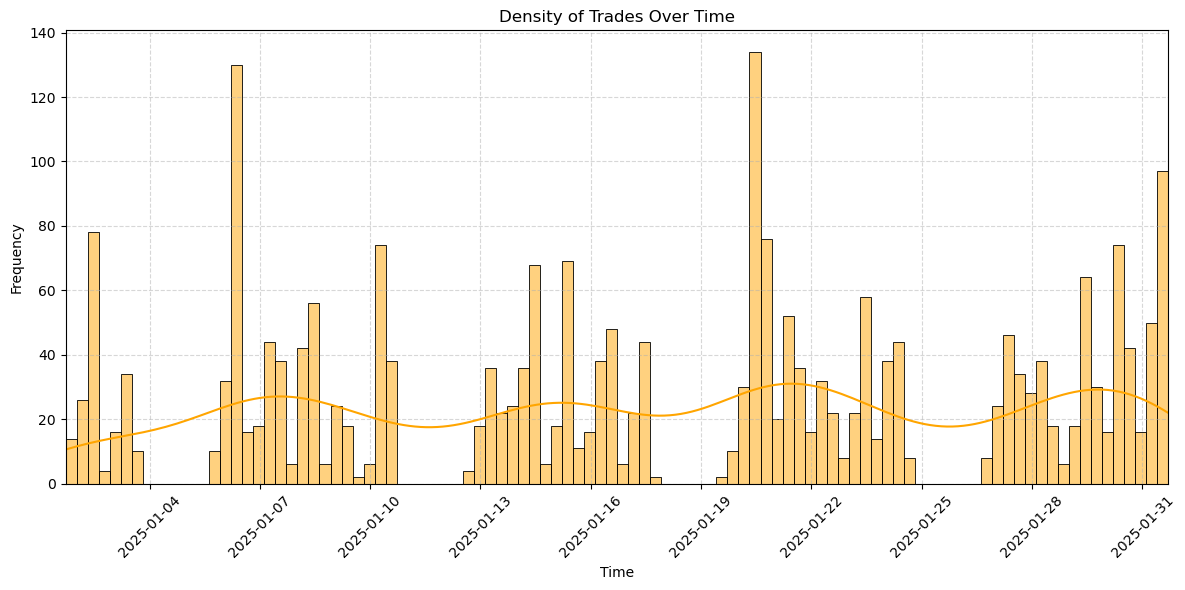

GBP/USD


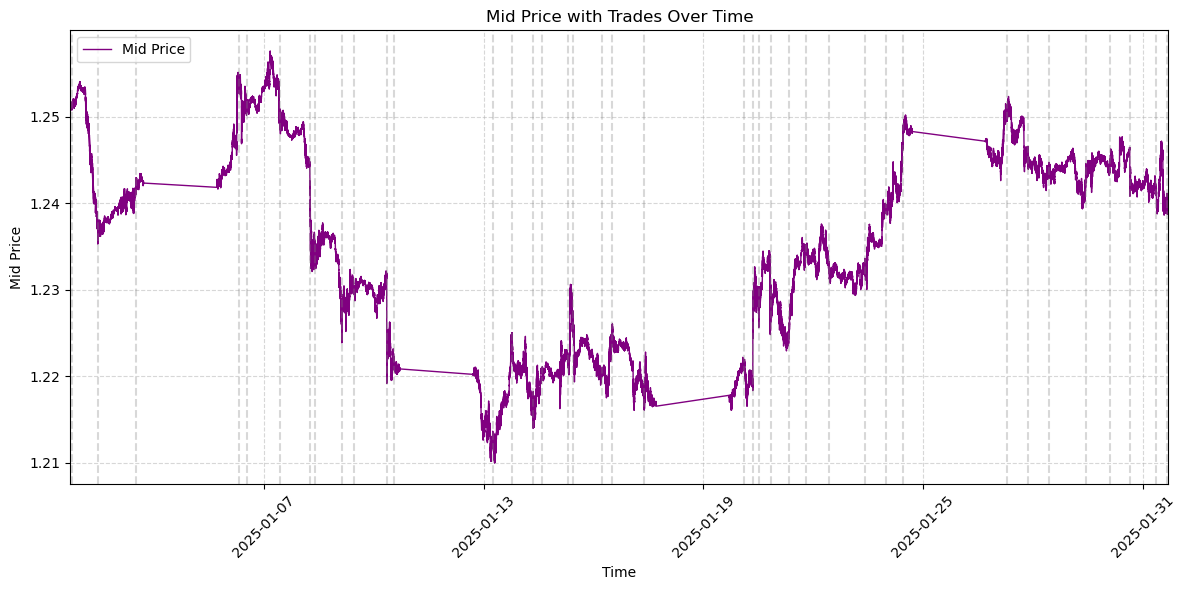

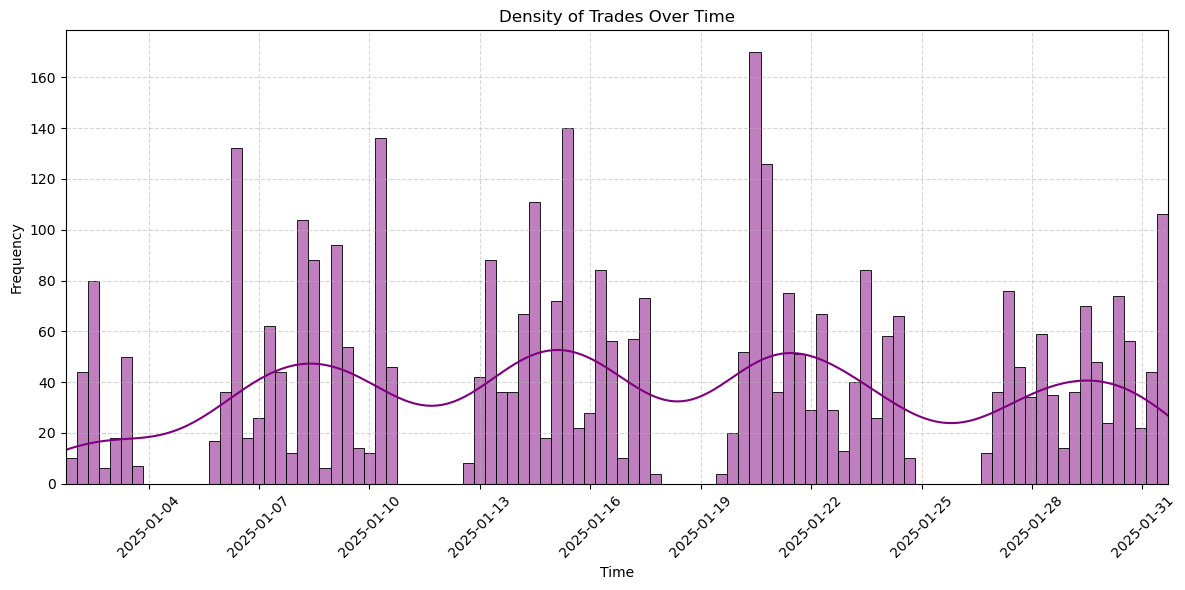

In [24]:
# Colors to distinguish charts
pairs_colors = {
    "NZD/JPY": ("blue", nzd_jpy_df),
    "EUR/USD": ("orange", eur_usd_df),
    "GBP/USD": ("purple", gbp_usd_df)
    }

# Variables to store trades for each pair
nzd_jpy_trades = eur_usd_trades = gbp_usd_trades = None

for pair_name, (color, df) in pairs_colors.items():
    
    # Setting Delta and Theta based on pairs
    if pair_name in ["EUR/USD", "GBP/USD"]:
        delta_up = delta_down = 0.0005
        theta = 0.0001
    else:
        delta_up = delta_down = 0.01
        theta = 0.001
    
    # Events and Trades from events
    events = intrinsic_event(df, delta_up, delta_down)
    trades = trading_strategy(df, events, theta)
    
    # Save trades to variables
    if pair_name == "NZD/JPY":
        nzd_jpy_trades = trades
    elif pair_name == "EUR/USD":
        eur_usd_trades = trades
    elif pair_name == "GBP/USD":
        gbp_usd_trades = trades
    
    # Visualization
    print(pair_name)
    visualize_signals(df, trades, color=color)
    plot_signal_density(trades, color=color)

## 1.8 Pseudocodes  <a id="pseudo"></a>

### 1.8.1 Intrinsic Time Framework <a id="itf"></a>
*[1]*

1: **if** first tick **then**     
2:   S_ext &larr; S_tick     
3:   S_IE &larr; S_tick     
4:   **return** `0`     

5: **else if** mode is "up" **then**     
6:   **if** S_tick - S_ext is >=  delta_up **then**     
7:    mode &larr; "down"     
8:    S_ext &larr; S_tick     
9:    S_IE &larr; S_tick     
10:    **return** `1`     
11:   **else if** S_tick < S_ext **then**     
12:    S_ext &larr; S_tick  
13:    **if**  S_IE - S_ext >= delta_down **then**   
14:     S_IE &larr; S_tick     
15:     **return** `-2`     
16:   **else**     
17:    **return** `0`     

18: **else if** mode is "down" **then**     
19:   **if** S_ext - S_tick >= delta_down **then**     
20:    mode &larr; "up"     
21:    S_ext &larr; S_tick     
22:    S_IE &larr; S_tick     
23:    **return** `-1`     
24:   **else if** S_tick > S_ext **then**     
25:    S_ext &larr; S_tick     
26:    **if** S_ext - S_IE >= delta_up **then**   
27:     S_IE &larr; S_tick     
28:     **return** `2`     
29:   **else**     
30:    **return** `0`     

### 1.8.2 Trading Strategy <a id="ts"></a>

1: **if** first event **then**  
2: &emsp; trades &larr; empty list  
3: &emsp; position &larr; None  
4: &emsp; P_DCC_up &larr; None  
5: &emsp; **return** trades  

6: **else for each** (timestamp, signal) in events **do**  
7: &emsp; P_C &larr; mid_price at timestamp  
8: &emsp; **if** signal=1 and position=None **then**  
9: &emsp;&emsp; P_DCC_up &larr; P_C  
10: &emsp;&emsp; entry_price &larr; ask_price at timestamp  
11: &emsp;&emsp; `Append` (timestamp, "BUY", entry_price) &rarr; trades  
12: &emsp;&emsp; position &larr; "LONG"  
13: &emsp;&emsp; **return** trades  

14: **else if** position="LONG" and P_C >= P_DCC_up × (1 + theta / 2) **then**  
15: &emsp;&emsp; exit_price &larr; bid_price at timestamp  
16: &emsp;&emsp; `Append` (timestamp, "SELL", exit_price) &rarr; trades  
17: &emsp;&emsp; position &larr; None  
18: &emsp;&emsp; **return** trades  

19: **else if** position="LONG" and P_C <= P_DCC_up × (1 - theta / 2) **then**  
20: &emsp;&emsp; exit_price &larr; bid_price at timestamp  
21: &emsp;&emsp; `Append` (timestamp, "SELL", exit_price) &rarr; trades  
22: &emsp;&emsp; position &larr; None  
23: &emsp;&emsp; **return** trades  

24: **else**  
25: &emsp; **return** trades

-------

# **<span style="color:blue">Part II: Testing your strategy</span>** <a id="Part-2"></a>

## 2.1 Strategy Backtesting Framework <a id="backtesting"></a>

In [26]:
def plot_pnl_over_time(pnl_list, timestamps, color):
    """
    Plots the cumulative PnL over time based on the backtesting results.

    Parameters:
        pnl_list (list): List of PnL values over time.
        timestamps (list): List of timestamps corresponding to each PnL value.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(timestamps, np.cumsum(pnl_list), label='Cumulative PnL', color=color)
    plt.title('Cumulative PnL Over Time')
    plt.xlabel('Time')
    plt.ylabel('Cumulative PnL')
    
    # x-axis formatting 
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()   


def backtest_trading_strategy(df, trades, color):
    """
    Backtests the trading strategy and provides performance metrics.

    Parameters:
        df (pd.DataFrame): DataFrame containing price and spread information.
        trades (list): List of trade signals with timestamps and action.

    Returns:
        dict: Performance metrics and statistics.
    """
    total_trades = len(trades)
    wins, losses = 0, 0
    largest_win, largest_loss = 0, 0
    total_return = 0
    hold_times = []
    pnl_list = []
    timestamps = []

    entry_price = None
    entry_time = None
    open_trade = False

    for i in range(total_trades):
        timestamp, action, price = trades[i]

        if action == 'BUY':  # Entry signal (open a trade)
            entry_price = price
            entry_time = timestamp
            open_trade = True

        elif action == 'SELL' and open_trade:  # Exit signal (close the trade)
            exit_price = price
            hold_time = (timestamp - entry_time).total_seconds() * 1000
            pnl = (exit_price - entry_price) / entry_price
            total_return += pnl
            pnl_list.append(pnl)
            timestamps.append(timestamp)

            # Track wins and losses
            if pnl > 0:
                wins += 1
                largest_win = max(largest_win, pnl)
            else:
                losses += 1
                largest_loss = min(largest_loss, pnl)

            hold_times.append(hold_time)
            open_trade = False

    # Handle any remaining open trades
    if open_trade:
        exit_price = df['bid_price'].iloc[-1]
        hold_time = (df.index[-1] - entry_time).total_seconds() * 1000
        pnl = (exit_price - entry_price) / entry_price
        total_return += pnl
        pnl_list.append(pnl)
        timestamps.append(df.index[-1])
        hold_times.append(hold_time)
        if pnl > 0:
            wins += 1
            largest_win = max(largest_win, pnl)
        else:
            losses += 1
            largest_loss = min(largest_loss, pnl)

    win_ratio = wins / (wins + losses) if (wins + losses) > 0 else 0
    shortest_hold = min(hold_times) if hold_times else 0
    longest_hold = max(hold_times) if hold_times else 0

    # Plot PnL over time
    plot_pnl_over_time(pnl_list, timestamps, color)

    performance = {
        'Total Pair Trades': wins + losses,
        'Total Wins': wins,
        'Total Losses': losses,
        'Win Ratio': round(win_ratio, 2),
        'Largest Win (%)': round(largest_win * 100, 3),
        'Largest Loss (%)': round(largest_loss * 100, 3),
        'Shortest Hold (ms)': shortest_hold,
        'Longest Hold (ms)': longest_hold,
        'Total Cumulative Return (%)': round(total_return * 100, 2)
    }
    return performance

## 2.2 Backtesting Results <a id="testresults"></a>

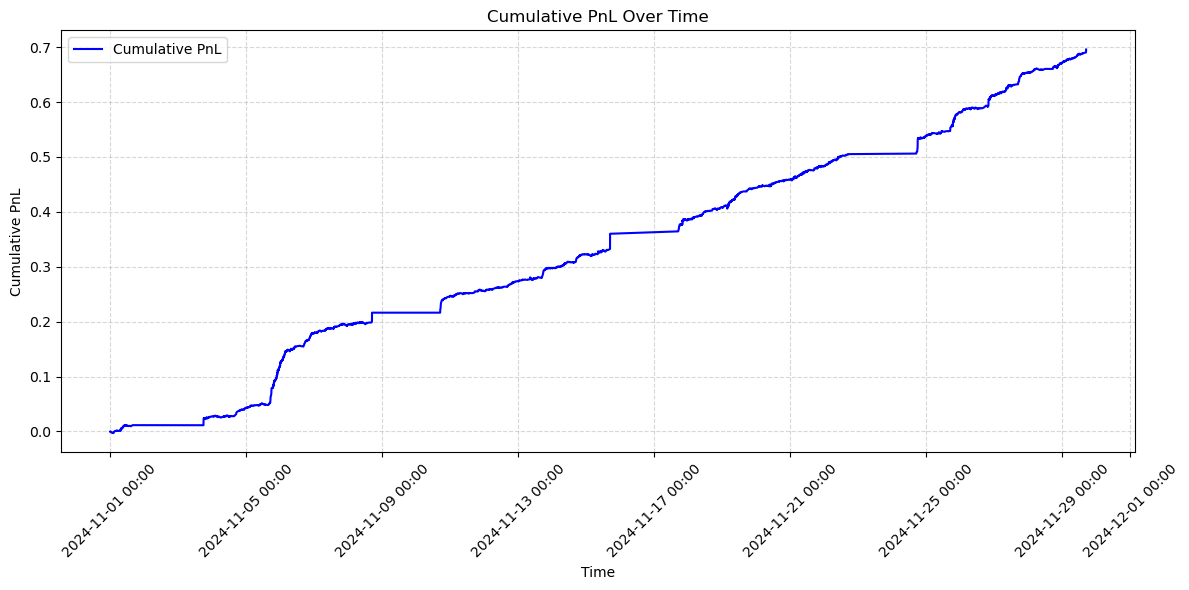

NZD/JPY Performance:
Total Pair Trades: 3203
Total Wins: 1679
Total Losses: 1524
Win Ratio: 0.52
Largest Win (%): 0.437
Largest Loss (%): -0.066
Shortest Hold (ms): 111.0
Longest Hold (ms): 180057447.0
Total Cumulative Return (%): 69.58




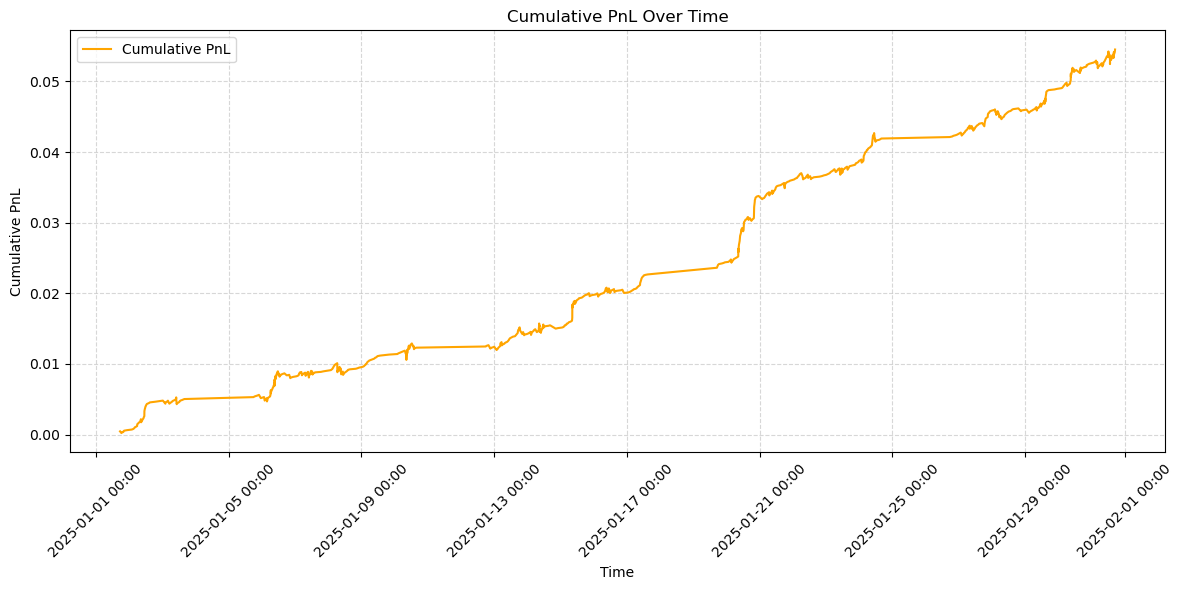

EUR/USD Performance:
Total Pair Trades: 1231
Total Wins: 1107
Total Losses: 124
Win Ratio: 0.9
Largest Win (%): 0.111
Largest Loss (%): -0.051
Shortest Hold (ms): 52.0
Longest Hold (ms): 2891349.0
Total Cumulative Return (%): 5.45




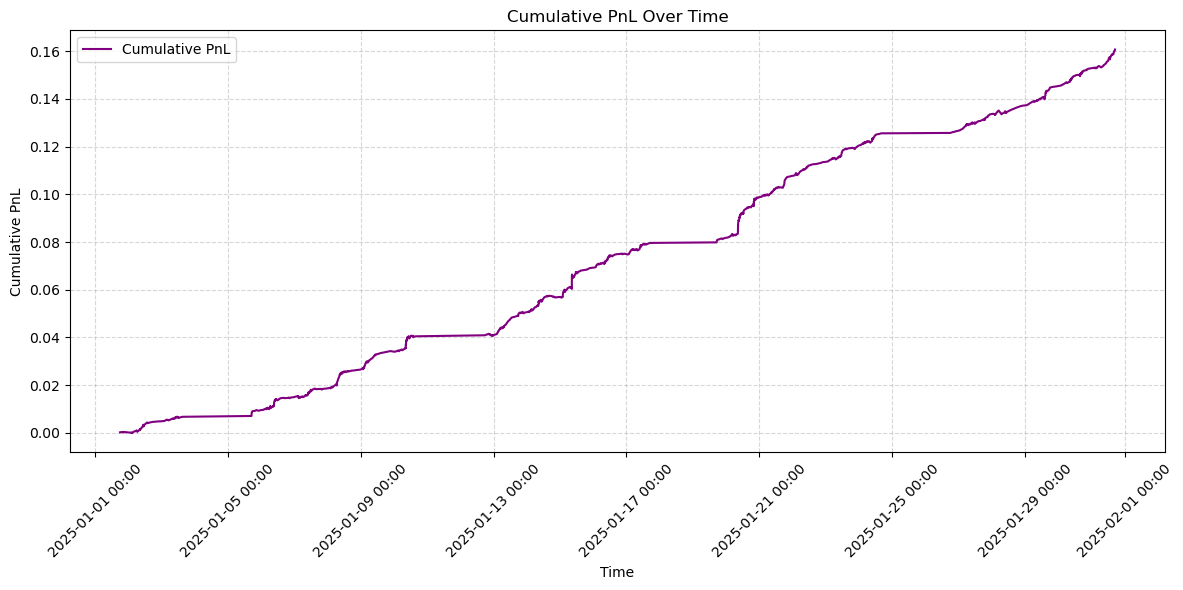

GBP/USD Performance:
Total Pair Trades: 1908
Total Wins: 1656
Total Losses: 252
Win Ratio: 0.87
Largest Win (%): 0.218
Largest Loss (%): -0.072
Shortest Hold (ms): 52.0
Longest Hold (ms): 172970692.0
Total Cumulative Return (%): 16.07




In [29]:
# Pairs dictionary with df, trades and colors
pairs = [
    ("NZD/JPY", nzd_jpy_df, nzd_jpy_trades, "blue", "\033[1;34m"),
    ("EUR/USD", eur_usd_df, eur_usd_trades, "orange", "\033[1;33m"),
    ("GBP/USD", gbp_usd_df, gbp_usd_trades, "purple", "\033[1;35m")
]

for pair_name, df, trades, color, color_code in pairs:
    performance = backtest_trading_strategy(df, trades, color)
    print(f"{color_code}{pair_name} Performance:\033[0m")
    for metric, value in performance.items():
        print(f"{metric}: {value}")
    print("\n")

## 2.3 Backtest Pseudocode <a id="backtestpseudocode"></a>

1: **`function`** backtest_trading_strategy(df, trades)  

2:   total_trades ← length of trades  
3:   wins, losses, largest_win, largest_loss, total_return ← 0  
4:   hold_times, pnl_list, timestamps ← []   
5:   entry_price, entry_time, open_trade ← None, None, False    

6: **for** i ← 0 to total_trades - 1  
7:   timestamp, action, price ← trades[i]    

8: **if** action = "BUY" **then**   
9:   entry_price ← price  
10:   entry_time ← timestamp  
11:   open_trade ← True  

12: **else if** action = "SELL" and open_trade = True **then**  
13:   exit_price ← price  
14:   hold_time ← (timestamp - entry_time) × 1000  
15:   pnl ← (exit_price - entry_price) / entry_price  
16:   total_return ← total_return + pnl  
17:   `append` pnl ← pnl_list  
18:   `append` timestamp ← timestamps  

19: **if** pnl > 0 **then**  
20:   wins ← wins + 1  
21:   largest_win ← max(largest_win, pnl)    
22: **else**  
23:   losses ← losses + 1    
24:   largest_loss ← min(largest_loss, pnl)  
25:   `append` hold_time ← hold_times  
26:   open_trade ← False    

27: **if** open_trade = True **then**  
28:   exit_price ← last bid_price from df  
29:   hold_time ← (df.index[-1] - entry_time) × 1000  
30:   pnl ← (exit_price - entry_price) / entry_price  
31:   total_return ← total_return + pnl  
32:   `append` pnl ← pnl_list  
33:   `append` df.index[-1] ← timestamps  
34:   `append` hold_time ← hold_times  

35: **if** pnl > 0 **then** 
36:   wins ← wins + 1    
37:   largest_win ← max(largest_win, pnl)  
38: **else**  
39:   losses ← losses + 1  
40:   largest_loss ← min(largest_loss, pnl)  

41: win_ratio ← wins / (wins + losses) if (wins + losses) > 0 else 0  
42: shortest_hold ← min(hold_times) if hold_times else 0  
43: longest_hold ← max(hold_times) if hold_times else 0  
44: Largest Win (%) ← largest_win × 100  
45: Largest Loss (%) ← largest_loss × 100  
46: Total Cumulative Return (%) ← total_return × 100  
47: **return** performance   

-------

# **<span style="color:blue">Results and Discussion</span>** <a id="RnD"></a>

different delta and theta usually needs to be applied on different currency pairs and therefore strategy of other markets too.

-------

# **<span style="color:blue">Conclusion</span>** <a id="Conclusion"></a>

-------

# **<span style="color:blue">References</span>** <a id="References"></a>

p.44 lecture 8